## Integrator Optimal Control

This notebook demonstrates how to use `SimInterface` with a simple optimal control example.

## Initialization

In [1]:
%matplotlib inline
import SimInterface as SI
import SimInterface.samplingControl as SC
import numpy as np
import matplotlib.pyplot as plt

## Defining the System

We will examine a simple optimal control problem:
\begin{equation*}
\begin{array}{cl}
\min_{u} &\int_0^T \left(x_t^2 + u_t^2\right) dt \\
\textrm{subject to } & \dot x_t = u_t,
\end{array}
\end{equation*}
with a fixed initial condition, $x_0 = 1$ and fixed final time $T$.

In [2]:
class Integrator(SI.linearQuadraticSystem):
    """
    This is the simplest linear system dynamical system
    """
    def __init__(self):
        self.dt = 0.1
        self.x0 = 1.0
        A = 1.
        B = self.dt
        Q = self.dt * 1.
        R = self.dt * 1.
        dynMat = SI.buildDynamicsMatrix(A,B)
        costMat = SI.buildCostMatrix(Cxx=Q,Cuu=R)
        SI.linearQuadraticSystem.__init__(self,dynamicsMatrix=dynMat,
                                           costMatrix=costMat,x0 = self.x0)
sys = Integrator()

The `linearQuadraticSystem` class implements dynamics of the form:
\begin{equation*}
    x_{k+1} = \begin{bmatrix}D_1 & D_x & D_u \end{bmatrix}
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}
\end{equation*}
with a quadratic cost given by
\begin{equation*}
    \sum_{k=0}^{N-1} 
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}'
    \begin{bmatrix}
    C_{11} & C_{1x} & C_{1u} \\
    C_{x1} & C_{xx} & C_{xu} \\
    C_{u1} & C_{ux} & C_{uu}
    \end{bmatrix}
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}.
\end{equation*}

In order to cast the integrator system into this form, we first perform an Euler approximation. We then utilize the helper functions `buildDynamicsMatrix` and `buildCostMatrix` to build the required matrices from the more common $A$, $B$, $Q$,and $R$ matrices.

## Controller Comparison

Now we will compare a several control methods. 

In [3]:
T = 100 # The Horizon
Controllers = [] # An empty list to store the controllers.

The most basic controller is a static gain:
\begin{equation*}
u_t = -\frac{1}{2} x_t
\end{equation*}

In [4]:
staticCtrl = SI.staticGain(gain=-.5,Horizon=T,label='Static')
Controllers.append(staticCtrl)

We can also use a linear quadratic regulator. Note that for the linear quadratic regulator, we pass the system as parameter to the control method, and then the regulator is constructed. 

A model predictive controller is constructed similarly.

In [5]:
lqrCtrl = SI.linearQuadraticRegulator(SYS=sys,Horizon=T,label='LQR')
Controllers.append(lqrCtrl)

mpcCtrl = SI.modelPredictiveControl(SYS=sys,
                                    predictiveHorizon=5,
                                    Horizon=T,
                                    label='MPC')
Controllers.append(mpcCtrl)

We can also compute control the control using only sequences of costs using an actor-critic algorithm.

In [6]:
actorCriticCtrl = SI.actorCriticLQR(SYS=sys,Horizon=T,
                                    Covariance=np.array([[1.0]]),
                                    EpisodeLength=50,EpisodeCount=500,
                                    TraceDecayFactor = .1,
                                    DiscountFactor = .9,
                                    ForgettingFactor = .9,
                                    label='Actor Critic')
Controllers.append(actorCriticCtrl)

Episode Cost: 2.82307, Estimated Episode Cost: 2.09
Episode Cost: 3.08395, Estimated Episode Cost: 3.91613
Episode Cost: 1.91416, Estimated Episode Cost: 2.18243
Episode Cost: 0.510299, Estimated Episode Cost: 0.767797
Episode Cost: 0.464679, Estimated Episode Cost: 0.788595
Episode Cost: 0.457469, Estimated Episode Cost: 0.759356
Episode Cost: 1.11734, Estimated Episode Cost: 0.703066
Episode Cost: 0.9581, Estimated Episode Cost: 0.937908
Episode Cost: 0.664087, Estimated Episode Cost: 0.720393
Episode Cost: 0.700567, Estimated Episode Cost: 0.691069
Episode Cost: 0.717256, Estimated Episode Cost: 0.730393
Episode Cost: 0.533923, Estimated Episode Cost: 0.678291
Episode Cost: 0.796859, Estimated Episode Cost: 0.823639
Episode Cost: 0.655142, Estimated Episode Cost: 0.675984
Episode Cost: 0.605392, Estimated Episode Cost: 0.646928
Episode Cost: 0.75857, Estimated Episode Cost: 0.785275
Episode Cost: 0.390398, Estimated Episode Cost: 0.605949
Episode Cost: 0.876078, Estimated Episode Co

## Comparison and Plotting

With all the controllers now defined, we can simulate each of them and plot the results.


Comparing Controllers

Static: 1.28201
LQR: 1.05125
MPC: 1.55746
Actor Critic: 6.62332


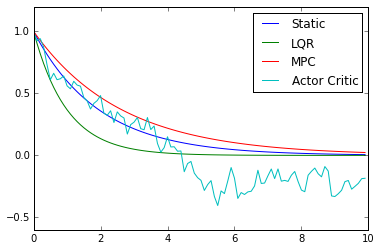

In [7]:
NumControllers = len(Controllers)
X = np.zeros((NumControllers,T,1))
Cost = np.zeros((NumControllers,T))
T = sys.dt * np.arange(staticCtrl.Horizon)
plt.figure(1)
plt.clf()
line = []

print '\nComparing Controllers\n'

for k in range(NumControllers):
    controller = Controllers[k]
    name = controller.label

    X[k], U, Cost[k] = sys.simulatePolicy(controller)
    print '%s: %g' % (name,Cost[k].sum())
    handle = plt.plot(T,X[k],label=name)[0]
    line.append(handle)

plt.legend(handles=line)

In [8]:
actorCriticCtrl.beta, actorCriticCtrl.C

(array([-0.06873459, -0.52755581]), array([[ 0.61160479]]))